# Measuring Hate Speech in Digital Text
##### The goal of this project is to use a Linear Regression supervised learning model to predict the Hate Speech 'score' of a text data source (tweet) using an annotated dataset of tweets. 
Predicting hate speech, or abusive speech, in digital text is a key business problem for any online community platform, whether it's social media, forums, video games, etc. Abusive communication from users can drive down platform use, leading to product shrinkage. 

In [1]:
import numpy as np
import scipy as sp
import sklearn.model_selection

#Visualization libraries
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

#Pandas dataframes
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

#NLP libraries
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

## Data Wrangling
Import HateSpeech dataset

In [2]:
'''
@article{kennedy2020constructing,
  title={Constructing interval variables via faceted Rasch measurement and multitask deep learning: a hate speech application},
  author={Kennedy, Chris J and Bacon, Geoff and Sahn, Alexander and von Vacano, Claudia},
  journal={arXiv preprint arXiv:2009.10277},
  year={2020}
}'''

'\n@article{kennedy2020constructing,\n  title={Constructing interval variables via faceted Rasch measurement and multitask deep learning: a hate speech application},\n  author={Kennedy, Chris J and Bacon, Geoff and Sahn, Alexander and von Vacano, Claudia},\n  journal={arXiv preprint arXiv:2009.10277},\n  year={2020}\n}'

In [3]:
import datasets 
dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech', 'binary')   
df = dataset['train'].to_pandas()
df.describe()

Using custom data configuration ucberkeley-dlab--measuring-hate-speech-7cb9b0b8e4d0e1dd
Reusing dataset parquet (C:\Users\DP185257\.cache\huggingface\datasets\parquet\ucberkeley-dlab--measuring-hate-speech-7cb9b0b8e4d0e1dd\0.0.0\0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


  0%|          | 0/1 [00:00<?, ?it/s]

,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hatespeech,hate_speech_score,infitms,outfitms,annotator_severity,std_err,annotator_infitms,annotator_outfitms,hypothesis,annotator_age
count,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.00000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135451.000000
mean,23530.416138,5567.097812,1.281352,2.954307,2.828875,2.56331,2.278638,2.698575,1.846211,1.052045,0.678413,2.625992,0.744733,-0.567428,1.034322,1.001052,-0.018817,0.300588,1.007158,1.011841,0.014589,37.910772
std,12387.194125,3230.508937,1.023542,1.231552,1.309548,1.38983,1.370876,0.898500,1.402372,1.345706,1.179598,1.114960,0.932260,2.380003,0.496867,0.791943,0.487261,0.236380,0.269876,0.675863,0.613006,11.641276
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-8.340000,0.100000,0.070000,-1.820000,0.020000,0.390000,0.280000,-1.578693,18.000000
25%,18148.000000,2719.000000,0.000000,2.000000,2.000000,2.00000,1.000000,2.000000,1.000000,0.000000,0.000000,2.000000,0.000000,-2.330000,0.710000,0.560000,-0.380000,0.030000,0.810000,0.670000,-0.341008,29.000000
50%,20052.000000,5602.500000,1.000000,3.000000,3.000000,3.00000,3.000000,3.000000,2.000000,0.000000,0.000000,3.000000,0.000000,-0.340000,0.960000,0.830000,-0.020000,0.340000,0.970000,0.850000,0.110405,35.000000
75%,32038.250000,8363.000000,2.000000,4.000000,4.000000,4.00000,3.000000,3.000000,3.000000,2.000000,1.000000,3.000000,2.000000,1.410000,1.300000,1.220000,0.350000,0.420000,1.170000,1.130000,0.449555,45.000000
max,50070.000000,11142.000000,3.000000,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,2.000000,6.300000,5.900000,9.000000,1.360000,1.900000,2.010000,9.000000,0.987511,81.000000


In [4]:
df.shape

(135556, 131)

Drop all non-core data features from original data set, sort by Comment_ID

In [5]:
target_cols=['hate_speech_score', 'text', 'comment_id', 'annotator_id', 'sentiment', 'respect', 'insult', 'humiliate', 'status', 'dehumanize', 'violence', 'genocide', 'attack_defend', 'hatespeech', 'annotator_severity']
df_focus= df[target_cols].sort_values(by=['comment_id'])
df_focus.head()

,hate_speech_score,text,comment_id,annotator_id,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hatespeech,annotator_severity
70119,0.46,White people are trash.,1,712,4.0,4.0,4.0,3.0,4.0,3.0,0.0,0.0,3.0,0.0,0.44
50410,0.46,White people are trash.,1,8185,3.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,3.0,0.0,-0.61
1064,0.46,White people are trash.,1,3330,4.0,3.0,3.0,3.0,3.0,2.0,1.0,0.0,3.0,0.0,0.18
23298,0.46,White people are trash.,1,962,4.0,4.0,3.0,2.0,3.0,3.0,0.0,0.0,4.0,0.0,0.10
36676,0.03,"You've caught the big gay, it's known to be ai...",2,4328,4.0,4.0,4.0,3.0,3.0,2.0,0.0,0.0,3.0,2.0,0.06


Check for missing data

In [6]:
df_focus.isna().sum()

hate_speech_score     0
text                  0
comment_id            0
annotator_id          0
sentiment             0
respect               0
insult                0
humiliate             0
status                0
dehumanize            0
violence              0
genocide              0
attack_defend         0
hatespeech            0
annotator_severity    0
dtype: int64

Visualization of target variable (Y) hate_speech_score

array([[<AxesSubplot:title={'center':'hate_speech_score'}>]], dtype=object)

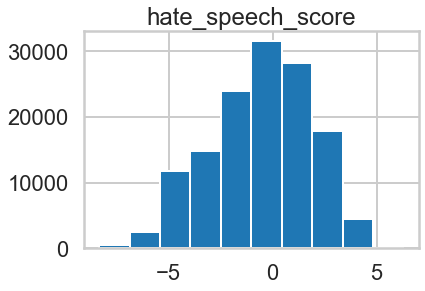

In [7]:
df_focus.hist('hate_speech_score')

Further drop the score columns, keeping only the target variable hate_speech_score

In [8]:
target_cols=['hate_speech_score', 'text']
df_text= df_focus[target_cols].reset_index(drop=True)
df_text.head()

,hate_speech_score,text
0,0.46,White people are trash.
1,0.46,White people are trash.
2,0.46,White people are trash.
3,0.46,White people are trash.
4,0.03,"You've caught the big gay, it's known to be ai..."


#### Now that the data is imported and appropriately formatted, we can begin on 
## Pre-processing Text

Remove all special characters, English stop words, and lowering case for all text

In [9]:
# necessary nltk downloads
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DP185257\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DP185257\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
df_text['clean_text'] = df_text['text'].str.replace('[^a-zA-Z]', ' ')
df_text['clean_text'] = df_text['clean_text'].str.lower()
df_text.head()
#df_text.text = word_tokenize(df_text.text.str.lower())

C:\Users\DP185257\AppData\Local\Temp/ipykernel_15612/2161992370.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_text['clean_text'] = df_text['text'].str.replace('[^a-zA-Z]', ' ')


,hate_speech_score,text,clean_text
0,0.46,White people are trash.,white people are trash
1,0.46,White people are trash.,white people are trash
2,0.46,White people are trash.,white people are trash
3,0.46,White people are trash.,white people are trash
4,0.03,"You've caught the big gay, it's known to be ai...",you ve caught the big gay it s known to be ai...


In [21]:
# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse

'''# Ex: getchunks([0,1,2,3,4,5,6,7], 4) => [[0,1,2,3], [4,5,6,7]]
def getchunks(iterable, chunk_size):
    size = len(iterable)
    if size < chunk_size:
        yield iterable
    chunks_nb = int(size / chunk_size)
    iter_ints = range(0, chunks_nb)
    for i in iter_ints:
        j = i * chunk_size
        if i+1 < chunks_nb:
            k = j + chunk_size
            yield iterable[j:k]
        else:
            yield iterable[j:]'''

#instantiate CountVectorizer, excluding vocabulary that does not occur in at least 10 tweets
cv_limited = CountVectorizer( 
    min_df=10, #words must appear in at least 10 tweets to be included
    stop_words='english'
)
#fit the CountVectorizer to create vocabulary (~9500 columns)
cv_trans= cv_limited.fit_transform(df_text['clean_text'])

'''#instantiate empty list for appending to, then load the 135556 rows of data in chunks of 25, transform them
      # and then append them to the empty list
dtm_chunked = []
for chunk in getchunks(df_text['clean_text'], 25):
    dtm_chunked.append(cv_limited.transform(chunk))
    
# matrices concates
dtm = sparse.vstack(dtm_chunked)
#print(dtm_chunked)
'''

"#instantiate empty list for appending to, then load the 135556 rows of data in chunks of 25, transform them\n      # and then append them to the empty list\ndtm_chunked = []\nfor chunk in getchunks(df_text['clean_text'], 25):\n    dtm_chunked.append(cv_limited.transform(chunk))\n    \n# matrices concates\ndtm = sparse.vstack(dtm_chunked)\n#print(dtm_chunked)\n"

In [22]:
cv_trans.toarray()

MemoryError: Unable to allocate 10.1 GiB for an array with shape (135556, 9959) and data type int64

In [12]:
'''


cv_trans= cv_limited.fit_transform(df_text['clean_text'])

# Print the full array
cv_array = cv_trans.toarray()

# Print the shape of cv_array
print(cv_array.shape)

# Create a DataFrame with these features
cv_df = pd.DataFrame(cv_array, 
                     columns=cv_limited.get_feature_names()).add_prefix('Counts_')

# Add the new columns to the original DataFrame
df_text_new = pd.concat([df_text, cv_df], axis=1, sort=False)
print(df_text_new.head())'''

(135556, 9959)


MemoryError: Unable to allocate 10.1 GiB for an array with shape (9959, 135556) and data type int64